### Constraint Satisfaction Problems 

#### Contents

* Overview
* Graph Coloring 
* N-Queens 
* AC-3
* Backtracking Search
* Tree CSP Solver
* Graph Coloring Visualization
* N-Queens Visualization

In [1]:
from csp import * 
from notebook import psource, pseudocode, plot_NQueens

# hide matplotlib warnings
import warnings
warnings.filterwarnings("ignore")

### Overview 

CSPs are a special kind of search problem. Here we don't treat the search space as a black box. The state has a particular form and we use that to our advantage to tweak our algorithms to be more suited to the problems. A CSP state is defined by a set of variables which can take values from corresponding domains. These variables can take only certain values in their domains to satisfy the constraints. A set of assignments which satisyf all contraints passes the goal test.



In [2]:
# explore CSP class 
psource(CSP)

### Graph Coloring 

In [3]:
# define colors for domain
colors = UniversalDict(['R', 'G', 'B'])
colors[5]

['R', 'G', 'B']

In [4]:
# define constraint function f(A, a, B, b). We need to ensure the neighbors have different colors 
psource(different_values_constraint)

In [5]:
# the csp class takes neighbors in the form of a dict.
%pdoc parse_neighbors

In [6]:
# MapColoringCSP creates and returns a CSP with the above constraint function and states 
psource(MapColoringCSP)

In [7]:
# look at example CSP
australia, usa, france

(<csp.CSP at 0x7f6d3c0c0e10>,
 <csp.CSP at 0x7f6d3c0f0780>)

In [8]:
# N-Queens 
psource(queen_constraint)


In [9]:
psource(NQueensCSP)

In [10]:
# initialize n-queens CSP object
eight_queens = NQueensCSP(8)

### Min-Conflicts 

The min-conflicts algorithm is an efficient method to solve a CSP. In the start, all the variables of the CSP are randomly initialized. The algorithm then randomly selects a variable that has conflicts and violates some constraints of the CSP. The selected variable is then assigned a value that minimizes the number of conflicts.

This is a simple stochastic algorithm which works on a principle similar to hill-climbing. The conflicting state is repeatedly changed into a state with fewer conflicts in an attempt to reach an approximate solution. This algorithm sometimes benefits from having a good initial assignments. Using greedy techniques to get a good initial assignment and then using min_conflicts to solve the CSP can speed up the procedure dramatically, especially for CSPs with a large state space 

In [11]:
# check min-conflicts source 
psource(min_conflicts)

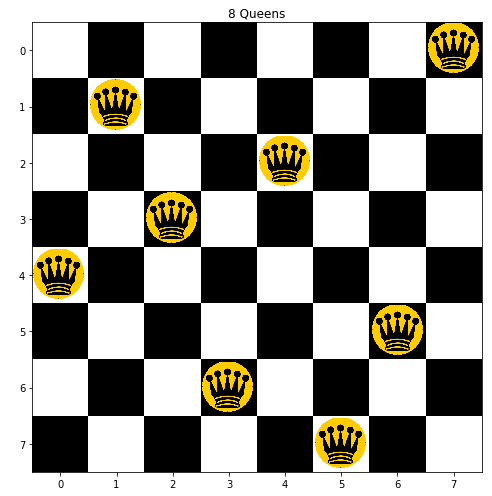

In [12]:
# use min conflicts to solve 8 queens 
solution = min_conflicts(eight_queens)

# plot
plot_NQueens(solution)

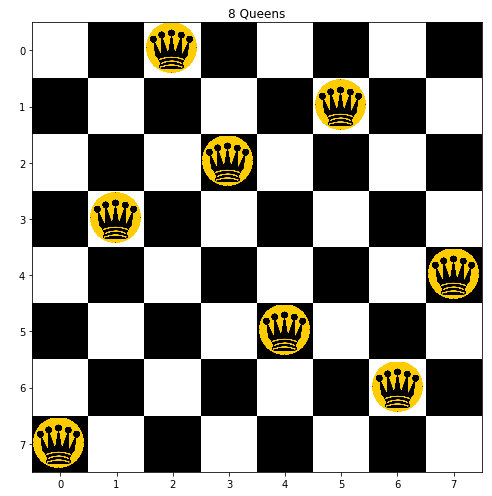

In [13]:
# try a different solution
eight_queens = NQueensCSP(8)
solution = min_conflicts(eight_queens)
plot_NQueens(solution)

#### Helper Functions 

We will implement a few helper functions that will allow us to visualize the coloring problem. We will also make a few modifications to the existing classes and functions for additional record keeping. 

In [14]:
# modify assign and unassign in CSP to add a copy of the assignment to the assignment_history
import copy
class InstruCSP(CSP):
    
    def __init__(self, variables, domains, neighbors, constraints):
        super().__init__(variables, domains, neighbors, constraints)
        self.assignment_history = []
        
    def assign(self, var, val, assignment):
        super().assign(var,val, assignment)
        self.assignment_history.append(copy.deepcopy(assignment))
    
    def unassign(self, var, assignment):
        super().unassign(var,assignment)
        self.assignment_history.append(copy.deepcopy(assignment))


In [15]:
# takes CSP and returns InstruCSP
def make_instru(csp):
    return InstruCSP(csp.variables, csp.domains, csp.neighbors, csp.constraints)

In [16]:
# create a graph for plotting purposes
neighbors = {
    0: [6, 11, 15, 18, 4, 11, 6, 15, 18, 4], 
    1: [12, 12, 14, 14], 
    2: [17, 6, 11, 6, 11, 10, 17, 14, 10, 14], 
    3: [20, 8, 19, 12, 20, 19, 8, 12], 
    4: [11, 0, 18, 5, 18, 5, 11, 0], 
    5: [4, 4], 
    6: [8, 15, 0, 11, 2, 14, 8, 11, 15, 2, 0, 14], 
    7: [13, 16, 13, 16], 
    8: [19, 15, 6, 14, 12, 3, 6, 15, 19, 12, 3, 14], 
    9: [20, 15, 19, 16, 15, 19, 20, 16], 
    10: [17, 11, 2, 11, 17, 2], 
    11: [6, 0, 4, 10, 2, 6, 2, 0, 10, 4], 
    12: [8, 3, 8, 14, 1, 3, 1, 14], 
    13: [7, 15, 18, 15, 16, 7, 18, 16], 
    14: [8, 6, 2, 12, 1, 8, 6, 2, 1, 12], 
    15: [8, 6, 16, 13, 18, 0, 6, 8, 19, 9, 0, 19, 13, 18, 9, 16], 
    16: [7, 15, 13, 9, 7, 13, 15, 9], 
    17: [10, 2, 2, 10], 
    18: [15, 0, 13, 4, 0, 15, 13, 4], 
    19: [20, 8, 15, 9, 15, 8, 3, 20, 3, 9], 
    20: [3, 19, 9, 19, 3, 9]
}

In [17]:
# create InstruCSP instance for our problem 
coloring_problem = MapColoringCSP('RGBY', neighbors)
coloring_problem1 = make_instru(coloring_problem)

#### Constraint Propagation 

Algorithms that solve CSPs have a choice between searching and or doing a constraint propagation (a specific type of inference). The constraints can be used to reduce the number of legal values for another variable, which in turn can reduce the legal values for some other variable, and so on. 

Constraint propagation tries to enforce local consistency. Consider each variable as a node in a graph and each binary constraint as an arc. Enforcing local consistency causes inconsistent values to be eliminated throughout the graph, a lot like the GraphPlan algorithm in planning (in which mutex links are removed from a planning graph). There are different types of local consistencies: 
    1. Node Consistency
    2. Arc Consistency
    3. Path Consistency
    4. K-Consistency
    5. Global Constraints

#### AC-3

A variable $X_i$ is arc-consistent with respect to another variabl $X_j$ if for every value in the current domain $D_i$ there is some value in the domain $D_j$ that satisfies the binary constraint on the arc $(X_i, X_j)$. A network is arc-consistent is every variable is arc-consistent with every other variable. 

AC-3 is an algorithm that enforces arc-consistency. After applying AC-3, either every arc is arc-consistent, or some variable has an empty domain, indicating that the CSP can not be solved. 

In [18]:
# AC3 source
psource(AC3)

In [19]:
# AC3 helper function 
psource(revise)

In [20]:
# define required variables to use AC3 
neighbors = parse_neighbors('A: B; B: ')
domains = {'A': [0, 1, 2, 3, 4], 'B': [0, 1, 2, 3, 4]}
constraints = lambda X, x, Y, y: x % 2 == 0 and (x + y) == 4 and y % 2 != 0
removals = []


In [21]:
# define csp object
csp = CSP(variables = None, domains = domains, neighbors = neighbors, constraints = constraints)

In [22]:
AC3(csp, removals = removals)

# this configuration is inconsistent

False

In [23]:
# rewrite constraints for consistency 
constraints = lambda X, x, Y, y: (x % 2) == 0 and (x + y) == 4
removals = []
csp = CSP(variables = None, domains = domains, neighbors = neighbors, constraints = constraints)

AC3(csp, removals = removals)

True

### Backtracking Search

The main issue with using naive search algorithms to solve a CSP is that they can continue to expand wrong paths. In backtracking search, we check the constraints as we go and we deal with only one variable at a time. The function takes a CSP as input and returns the correct assignment if it satisfies the goal. 

In [24]:
# solve coloring 
result = backtracking_search(coloring_problem1)
result

{0: 'R',
 1: 'R',
 2: 'R',
 3: 'R',
 4: 'G',
 5: 'R',
 6: 'G',
 7: 'R',
 8: 'B',
 9: 'R',
 10: 'G',
 11: 'B',
 12: 'G',
 13: 'G',
 14: 'Y',
 15: 'Y',
 16: 'B',
 17: 'B',
 18: 'B',
 19: 'G',
 20: 'B'}

In [25]:
# check the number of assignments made
coloring_problem1.nassigns

21

In [26]:
# check num of assigns and unassigns
len(coloring_problem1.assignment_history)

21

Backtracking search takes additional keyword arguments that help speed the assignment further. 

The first one is select_unassigned_variable. It takes as input a function that helps in deciding the order in which the variables will be selected for assignment. We will use a heuristic called Most Restricted Variable which is implemented by the function mrv. 

The idea behind mrv is to choose the variable with the least legal values left in its domain. The intuition behind mrv or the most constrained variable is that it allows us to encounter failure quickly before going too deep into a tree if we have selected a wrong step before. The mrv implementation makes use of another function num_legal_values to sort out the variables by the number of legal values left in its domain. This function, in turn, calls the nconflicts method of the CSP to return such values

In [27]:
psource(mrv)

In [28]:
psource(num_legal_values)

In [29]:
psource(CSP.nconflicts)

Another ordering related parameter is order_domain_values. Here we use the Least Constraining Value heuristic, which is implemented by the function lcv. The idea is to select the value which rules out the least number of values in the remaining ariables. The intuition behind selecting the lcv is that it allows a lot of freedom to assign values later. The idea behind selecting the mrc and lcv makes sense because we need to do all variables but for values its better to try ones that are more likely. 

In [30]:
psource(lcv)

The third parameter, inference can make use of one of the two techniques called arc consistency or forward checking. The idea is to detect the possible failure before it occurs and to look ahead to not make mistakes. mac and forward_checking implement these techniques. 

In [31]:
# compare performance with these parameters enabled 
solve_simple = copy.deepcopy(usa)
solve_parameters = copy.deepcopy(usa)

In [32]:
backtracking_search(solve_simple)
backtracking_search(solve_parameters, order_domain_values = lcv, select_unassigned_variable = mrv, inference = mac)

{'MT': 'R',
 'SD': 'G',
 'WY': 'B',
 'ND': 'B',
 'NE': 'R',
 'IA': 'B',
 'CO': 'G',
 'ID': 'G',
 'KA': 'B',
 'MN': 'R',
 'MO': 'G',
 'OK': 'R',
 'UT': 'R',
 'IL': 'R',
 'WI': 'G',
 'KY': 'B',
 'AR': 'B',
 'IN': 'G',
 'NV': 'B',
 'TN': 'R',
 'AZ': 'G',
 'OH': 'R',
 'WV': 'G',
 'VA': 'Y',
 'CA': 'R',
 'OR': 'Y',
 'PA': 'B',
 'MD': 'R',
 'DE': 'G',
 'DC': 'G',
 'NM': 'B',
 'MS': 'G',
 'NJ': 'R',
 'NC': 'G',
 'GA': 'B',
 'AL': 'Y',
 'WA': 'R',
 'LA': 'R',
 'FL': 'R',
 'SC': 'R',
 'TX': 'G',
 'MI': 'B',
 'NY': 'G',
 'CT': 'R',
 'MA': 'B',
 'VT': 'R',
 'NH': 'G',
 'RI': 'G',
 'ME': 'R'}

In [33]:
solve_simple.nassigns

49

In [34]:
solve_parameters.nassigns

49

### Tree CSP Solver 

The tree_csp_solver function can be used to solve problems whose constraint graph is a tree. Given a csp with neighbors forming a tree, it returns an assignment that satisfies the given constraints. 

First it finds the topological sort of the tree. This is an ordering of the tree where each variable / node comes after its parent in the tree. The function that accomplishes this is topological_sort. Topological sort is an augmented depth first search. 

Then the tree_csp_solver enforces arc consistency. Acr consistency between two variables, a and b, occurs when for every possible value of a there is an assignment in b that satisfies the problem's constraints. If such an assignment can't be found, then the problematic value is removed from a's possible values. If an arc can not be made consistent, then the solver fails. If every arc is made consistent then we move onto assigning values. 



In [35]:
psource(tree_csp_solver)

In [36]:
# define the map coloring problem for australia 
australia_small = MapColoringCSP(list('RB'), 'NT: WA Q; NSW: Q V')

In [37]:
# put australia_small into tree_csp_solver 
assignment = tree_csp_solver(australia_small)
print(assignment)

{'NT': 'R', 'Q': 'B', 'NSW': 'R', 'V': 'B', 'WA': 'B'}


### Graph Coloring Visualization

In [38]:
%matplotlib inline 
import networkx as nx 
import matplotlib.pyplot as plt 
import matplotlib
import time 

In [39]:
# create step function for input to graph visualization
def make_update_step_function(graph, instru_csp):
    # define a function to draw the graphs 
    def draw_graph(graph): 
        G = nx.Graph(graph)
        pos = nx.spring_layout(G, k = 0.15)
        return (G, pos)

    G, pos = draw_graph(graph)
    
    def update_step(iteration): 
        # here iteration is the index of the assignment history we want to visualize
        current = instru_csp.assignment_history[iteration]
        # convert assignment to a default dict so unassigned nodes are black 
        current = defaultdict(lambda: 'Black', current)
        # set colors in the list 
        colors = [current[node] for node in G.node.keys()]
        # draw nodes and assign labels 
        nx.draw(G, pos, node_color = colors, node_size = 500)
        labels = {label: label for label in G.node}
        # shift labels by offset to prevent overlap 
        label_pos = {key:[value[0], value[1]+0.03] for key, value in pos.items()}
        nx.draw_networkx_labels(G, label_pos, labels, font_size = 20)
        # display the graph 
        plt.show()
    return update_step # returns function 

def make_visualize(slider): 
    # takes as input a slide and returns callback function for timer and animation 
    def visualize_callback(Visualize, time_step): 
        if Visualize is True: 
            for i in range(slider.min, slider.max + 1): 
                slider.value = i
                time.sleep(float(time_step))
    return visualize_callback

In [40]:
# plot our problem 
step_func = make_update_step_function(neighbors, coloring_problem1)

# set canvas size
matplotlib.rcParams['figure.figsize'] = (18.0, 18.0)

In [41]:
import ipywidgets as widgets
from IPython.display import display

iteration_slider = widgets.IntSlider(min=0, max=len(coloring_problem1.assignment_history)-1, step=1, value=0)
w=widgets.interactive(step_func,iteration=iteration_slider)
display(w)

visualize_callback = make_visualize(iteration_slider)

visualize_button = widgets.ToggleButton(description = "Visualize", value = False)
time_select = widgets.ToggleButtons(description='Extra Delay:',options=['0', '0.1', '0.2', '0.5', '0.7', '1.0'])

a = widgets.interactive(visualize_callback, Visualize = visualize_button, time_step=time_select)
display(a)

interactive(children=(IntSlider(value=0, description='iteration', max=20), Output()), _dom_classes=('widget-in…

interactive(children=(ToggleButton(value=False, description='Visualize'), ToggleButtons(description='Extra Del…

### N-Queens Visualization

In [48]:
def label_queen_conflicts(assignment,grid):
    #Mark grid with queens that are under conflict.
    for col, row in assignment.items(): # check each queen for conflict
        conflicts = {temp_col:temp_row for temp_col,temp_row in assignment.items() 
                         if (temp_row == row and temp_col != col)
                          or (temp_row+temp_col == row+col and temp_col != col)
                          or (temp_row-temp_col == row-col and temp_col != col)}
        
        # Place a 3 in positions where this is a conflict
        for col, row in conflicts.items():
                grid[col][row] = 3

    return grid

def make_plot_board_step_function(instru_csp):
    '''
   ipywidgets interactive function supports
   single parameter as input. This function
   creates and return such a function by taking
   in input other parameters.
    '''
    n = len(instru_csp.variables)
    
    
    def plot_board_step(iteration):
        ''' Add Queens to the Board.'''
        data = instru_csp.assignment_history[iteration]
        
        grid = [[(col+row+1)%2 for col in range(n)] for row in range(n)]
        grid = label_queen_conflicts(data, grid) # Update grid with conflict labels.
        
        # color map of fixed colors
        cmap = matplotlib.colors.ListedColormap(['white','lightsteelblue','red'])
        bounds=[0,1,2,3] # 0 for white 1 for black 2 onwards for conflict labels (red).
        norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
        
        fig = plt.imshow(grid, interpolation='nearest', cmap = cmap,norm=norm)

        plt.axis('off')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

        # Place the Queens Unicode Symbol
        for col, row in data.items():
            fig.axes.text(row, col, u"\u265B", va='center', ha='center', family='Dejavu Sans', fontsize=32)
        plt.show()
    
    return plot_board_step


In [43]:
# visualize backtracking solution 
twelve_queens_csp = NQueensCSP(12)
backtracking_instru_queen = make_instru(twelve_queens_csp)
result = backtracking_search(backtracking_instru_queen)

# step function for widgets 
backtrack_queen_step = make_plot_board_step_function(backtracking_instru_queen)

In [49]:
# visualize
matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)
matplotlib.rcParams['font.family'].append(u'Dejavu Sans')

iteration_slider = widgets.IntSlider(min=0, max=len(backtracking_instru_queen.assignment_history)-1, step=0, value=0)
w=widgets.interactive(backtrack_queen_step,iteration=iteration_slider)
display(w)

visualize_callback = make_visualize(iteration_slider)

visualize_button = widgets.ToggleButton(description = "Visualize", value = False)
time_select = widgets.ToggleButtons(description='Extra Delay:',options=['0', '0.1', '0.2', '0.5', '0.7', '1.0'])

a = widgets.interactive(visualize_callback, Visualize = visualize_button, time_step=time_select)
display(a)

interactive(children=(IntSlider(value=0, description='iteration', max=473, step=0), Output()), _dom_classes=('…

interactive(children=(ToggleButton(value=False, description='Visualize'), ToggleButtons(description='Extra Del…

In [45]:
# repeat above for min_conflicts 
conflicts_instru_queen = make_instru(twelve_queens_csp)
result = min_conflicts(conflicts_instru_queen)
conflicts_step = make_plot_board_step_function(conflicts_instru_queen)

In [46]:
iteration_slider = widgets.IntSlider(min=0, max=len(conflicts_instru_queen.assignment_history)-1, step=0, value=0)
w=widgets.interactive(conflicts_step,iteration=iteration_slider)
display(w)

visualize_callback = make_visualize(iteration_slider)

visualize_button = widgets.ToggleButton(description = "Visualize", value = False)
time_select = widgets.ToggleButtons(description='Extra Delay:',options=['0', '0.1', '0.2', '0.5', '0.7', '1.0'])

a = widgets.interactive(visualize_callback, Visualize = visualize_button, time_step=time_select)
display(a)


interactive(children=(IntSlider(value=0, description='iteration', max=26, step=0), Output()), _dom_classes=('w…

interactive(children=(ToggleButton(value=False, description='Visualize'), ToggleButtons(description='Extra Del…